# Demo of SF error analysis
*Semi-empirical approach to computing second-order statistics of gapped series*

Statistical moments of increments. 
$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import utils as utils  # copied directly from Reynolds project, normalize() added
import sf_funcs as sf
import pickle

plt.rcParams.update({"font.size": 12})

# Set seed for reproducibility
np.random.seed(42)

## Load in the data
A magnetic field time series from PSP, already processed into Pandas DataFrame format

In [ ]:
df_raw_full = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
df_raw = df_raw_full["B_R"]
df_raw.head()

Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64

Optionally, check the data for missing data and its frequency, get summary stats

In [ ]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###

510 missing points
Length of interval: 7522952
Duration of interval: 0 days 17:59:59.987519872
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = nan
Standard deviation = nan


## Standardise each interval 
to contain 8 correlation times `tc`. Start with *approximately* 15 correlation times across 75,000 points, then calculate correlation time and use this value to down-sample to 8 correlation times across 10,000 points.

In [ ]:
tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

In [ ]:
# Original freq is 0.007s. Resampling to less rapid but still sufficiently high cadence, then splitting into chunks with ~15 correlation times

tc_approx = 500  # s
tc_approx_n = 15
cadence_approx = 0.1  # s

tc_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tc_approx * tc_approx_n / cadence_approx)

# We have approximately 15 correlation times in 10,000 points. Let's now be more precise, and calculate the correlation time from each chunk

# Split df into subsets
interval_list_approx = [
    df[i : i + interval_length_approx]
    for i in range(0, len(df) - interval_length_approx + 1, int(interval_length_approx))
]

del df  # free up memory

tc_list = []

for interval_approx in interval_list_approx:
    time_lags_lr, r_vec_lr = utils.compute_nd_acf(
        [interval_approx],
        nlags=10000,
        plot=False,
    )

    tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

    if tc == -1:
        tc = 500
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce not found for this chunk, setting to 500s (default) -> cadence = {new_cadence}s"
        )

    else:
        new_cadence = tc_n * tc / interval_length
        print(
            f"tce calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tce across {interval_length} points)"
        )

    tc_list.append(tc)

    interval_approx_resampled = interval_approx.resample(
        str(new_cadence) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        int_norm = utils.normalize(interval)
        good_inputs_list.append(int_norm)

print(
    "\nNumber of standardised intervals: "
    + str(len(good_inputs_list))
    + "\n(may be more than one per original chunk for small cadences)"
)

tce calculated to be 472.44s -> cadence = 0.94s (for 8tce across 4000 points)
tce calculated to be 519.81s -> cadence = 1.04s (for 8tce across 4000 points)
tce calculated to be 724.28s -> cadence = 1.45s (for 8tce across 4000 points)
tce calculated to be 612.58s -> cadence = 1.23s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s
tce calculated to be 181.96s -> cadence = 0.36s (for 8tce across 4000 points)
tce calculated to be 860.62s -> cadence = 1.72s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s

Number of standardised intervals: 12
(may be more than one per original chunk for small cadences)


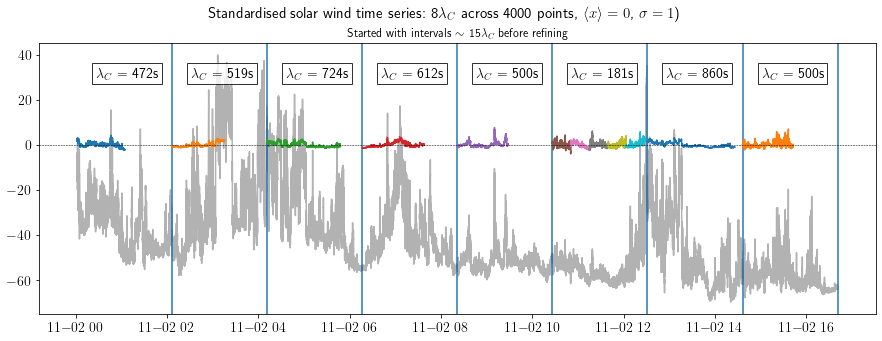

In [ ]:
plt.rcParams.update({"font.size": 14})

fig, ax = plt.subplots(figsize=(15, 5))
[plt.plot(interval, alpha=0.3, c="black") for interval in interval_list_approx]
[plt.axvline(interval.index[-1]) for interval in interval_list_approx]
[plt.plot(interval) for interval in good_inputs_list]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
for index, tc in enumerate(tc_list):
    plt.text(
        x=interval_list_approx[index].index[0] + pd.Timedelta(seconds=1500),
        y=30,
        s=f"$\lambda_C$ = {int(tc)}s",
        bbox=dict(facecolor="white", alpha=0.8),
    )
plt.suptitle(
    f"Standardised solar wind time series: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$)",
    fontsize=15,
)
# Add subtitle
plt.title("Started with intervals $\sim$ 15$\lambda_C$ before refining", fontsize=12)

plt.show()
plt.rcParams.update({"font.size": 12})

Mostly, we can just fit one time series of 8tc into each original one of about 2 hours. (8tc is approx 80min).

In [ ]:
for interval in good_inputs_list:
    print(len(interval))

4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000
4000


## Get gapped statistics
Remove data from each input multiple times and compute SF, naive and interpolated

*Could use bin setting ability from heatmap to get binning of SF calculation*

In [ ]:
def compute_sf(data, lags, powers=[2], retain_increments=False, bin_width=0):
    """
    Routine to compute the increments of a time series and then the mean (structure function) and standard deviation
    of the PDF of these increments, raised to the specified powers.
    Input:
            data: pd.DataFrame of data to be analysed. Must have shape (1, N) or (3, N)
            lags: The array consisting of lags, being the number of points to shift each of the series
            powers: The array consisting of the Structure orders to perform on the series for all lags
    Output:
            df: The DataFrame containing  corresponding to lags for each order in powers
    """
    # run through lags and powers so that for each power, run through each lag
    df = {}

    if data.shape[1] == 1:
        ax = data.iloc[:, 0].copy()
        for i in powers:
            array = []
            mean_array = []
            mapd_array = []
            std_array = []
            N_array = []

            for lag in lags:
                lag = int(lag)
                dax = np.abs(ax.shift(-lag) - ax)
                strct = dax.pow(i)
                array += [strct.values]

                strct_mean = strct.mean()
                median_abs_diff = np.nanmedian(np.abs(dax))
                mean_array += [strct_mean]
                mapd_array += [median_abs_diff]
                strct_std = strct.std()
                std_array += [strct_std]

                N = dax.notnull().sum()
                N_array += [N]

            if i == 2:
                df["lag"] = lags
                df["n"] = N_array
                df["sosf"] = mean_array
                df["mapd"] = mapd_array
                df["sosf_se"] = np.array(std_array) / np.sqrt(N_array)
                if retain_increments is True:
                    df["sq_diffs"] = array

            else:
                df["n"] = N_array
                df[str(i) + "_mean"] = mean_array
                df[str(i) + "_std"] = std_array
                df[str(i) + "_std_err"] = np.array(std_array) / np.sqrt(N_array)
                if retain_increments is True:
                    df[str(i) + "_diffs"] = array

    else:
        raise ValueError(
            "This version only accepts scalar series: data must be a pd.DataFrame of shape (1, N)"
        )

    df = pd.DataFrame(df, index=lags)
    # calculate sample size as a proportion of the maximum sample size (for that lag)
    df["missing_prop"] = 1 - (df["n"] / (len(ax) - df.index))
    return df

In [ ]:
# Subsetting for testing
good_inputs_list = good_inputs_list[:5]

In [ ]:
# Logarithmically-spaced lags
# lags = np.unique(
#     np.logspace(0, np.log10(0.25 * len(good_inputs_list[0])), 10).astype(int)
# )
lags = np.arange(0, 0.25 * len(good_inputs_list[0]))

powers = [2]
times_to_gap = 4

good_outputs_list = []
all_bad_inputs_list = []
all_bad_outputs_list = []
all_interp_inputs_list = []
all_interp_outputs_list = []

for i, input in enumerate(good_inputs_list):
    print("\nProcessing input {}".format(i))
    good_output = sf.compute_sf(pd.DataFrame(input), lags, powers)
    good_outputs_list.append(good_output)

    bad_inputs_list = []
    bad_outputs_list = []
    interp_inputs_list = []
    interp_outputs_list = []

    for total_removal in np.random.uniform(0, 0.9, times_to_gap):
        # Remove data (up to about 90%, may be some numerical issues with large %)
        # in both chunks and uniformly - split given by ratio_removal
        ratio_removal = np.random.uniform()
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )

        print(
            "Removed {0:.1f}% (approx. {1:.1f}% in chunks, {2:.1f}% uniformly)".format(
                prop_removed * 100, prop_remove_chunks * 100, prop_remove_unif * 100
            )
        )

        bad_inputs_list.append(bad_input.values)

        # Linearly interpolate the missing data
        interp_input = bad_input.interpolate(method="linear")
        interp_inputs_list.append(interp_input.values)

        bad_output = sf.compute_sf(pd.DataFrame(bad_input), lags, powers)
        bad_output["error"] = bad_output["sosf"] - good_output["sosf"]
        bad_output["error_percent"] = bad_output["error"] / good_output["sosf"] * 100
        bad_output["missing_prop_overall"] = prop_removed
        bad_output["lint"] = False
        bad_outputs_list.append(bad_output)

        interp_output = sf.compute_sf(pd.DataFrame(interp_input), lags, powers)
        interp_output["error"] = interp_output["sosf"] - good_output["sosf"]
        interp_output["error_percent"] = (
            interp_output["error"] / good_output["sosf"] * 100
        )
        interp_output["missing_prop_overall"] = prop_removed
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["sosf_se"] = bad_output["sosf_se"]
        # NOTE: Seems sensible uncertainty is the same for both
        interp_output["lint"] = True
        interp_outputs_list.append(interp_output)

    all_bad_inputs_list.append(bad_inputs_list)
    all_bad_outputs_list.append(bad_outputs_list)
    all_interp_inputs_list.append(interp_inputs_list)
    all_interp_outputs_list.append(interp_outputs_list)

# converting from pd.Series to list of np.arrays to save space
all_good_inputs_list = [interval.values for interval in good_inputs_list]


Processing input 0
Removed 32.4% (approx. 5.3% in chunks, 28.4% uniformly)


Removed 65.4% (approx. 37.4% in chunks, 48.2% uniformly)
Removed 58.4% (approx. 49.5% in chunks, 16.4% uniformly)
Removed 39.9% (approx. 45.8% in chunks, 8.1% uniformly)

Processing input 1
Removed 52.2% (approx. 41.7% in chunks, 25.3% uniformly)
Removed 51.2% (approx. 72.4% in chunks, 2.7% uniformly)
Removed 30.9% (approx. 2.9% in chunks, 28.8% uniformly)
Removed 5.5% (approx. 3.2% in chunks, 2.5% uniformly)

Processing input 2
Removed 61.9% (approx. 80.0% in chunks, 7.7% uniformly)
Removed 1.2% (approx. 0.9% in chunks, 0.4% uniformly)
Removed 51.6% (approx. 68.5% in chunks, 18.0% uniformly)
Removed 70.1% (approx. 6.3% in chunks, 68.3% uniformly)

Processing input 3
Removed 13.5% (approx. 3.2% in chunks, 10.6% uniformly)
Removed 11.3% (approx. 1.6% in chunks, 9.9% uniformly)
Removed 39.7% (approx. 30.8% in chunks, 28.7% uniformly)
Removed 50.9% (approx. 37.3% in chunks, 21.6% uniformly)

Processing input 4
Removed 8.2% (approx. 6.0% in chunks, 2.3% uniformly)
Removed 34.0% (approx. 43

In [ ]:
with open("data/processed/sfs_psp.pkl", "wb") as f:
    pickle.dump(
        [
            good_inputs_list,
            good_outputs_list,
            all_bad_inputs_list,
            all_bad_outputs_list,
            all_interp_inputs_list,
            all_interp_outputs_list,
        ],
        f,
    )

 Crashed on the following attempts:

` Nominal total removal: 2.5%
Nominal ratio: 1.1%`

`Nominal total removal: 52.0%
Nominal ratio: 0.1%`

## UP TO HERE ON RĀPOI

---

## Check a sample of results, for a given source interval

In [ ]:
# Read in pickle file data/processed/list_of_list_of_dfs.pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ts_dashboard_utils as ts
import utils as utils  # copied directly from Reynolds project, normalize() added
import sf_funcs as sf
import pickle

with open("data/processed/sfs_psp.pkl", "rb") as f:
    list_of_list_of_dfs = pickle.load(f)

# Unpack the list of list of dfs
(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
) = list_of_list_of_dfs

In [ ]:
print(
    f"{len(all_interp_outputs_list[0])} versions of {len(all_interp_outputs_list)} outputs"
)

20 versions of 1271 outputs


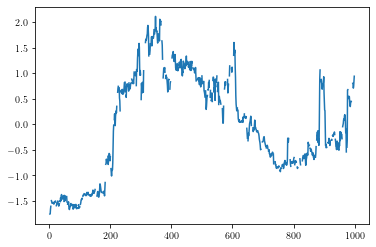

In [ ]:
plt.plot(all_bad_inputs_list[8][5])

### Naive

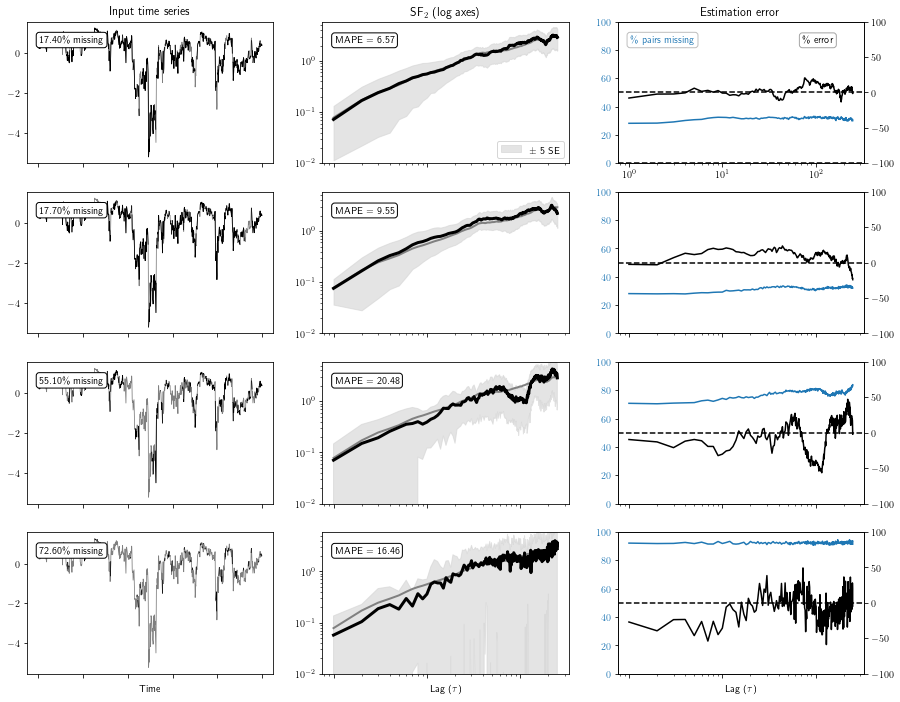

In [ ]:
# Check results, for a given clean input

input_ind = 30
n = 4

sf.plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    "C0",
    input_ind,
    n,
    False,
)

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, reflecting the increased uncertainty of fewer *true* observations

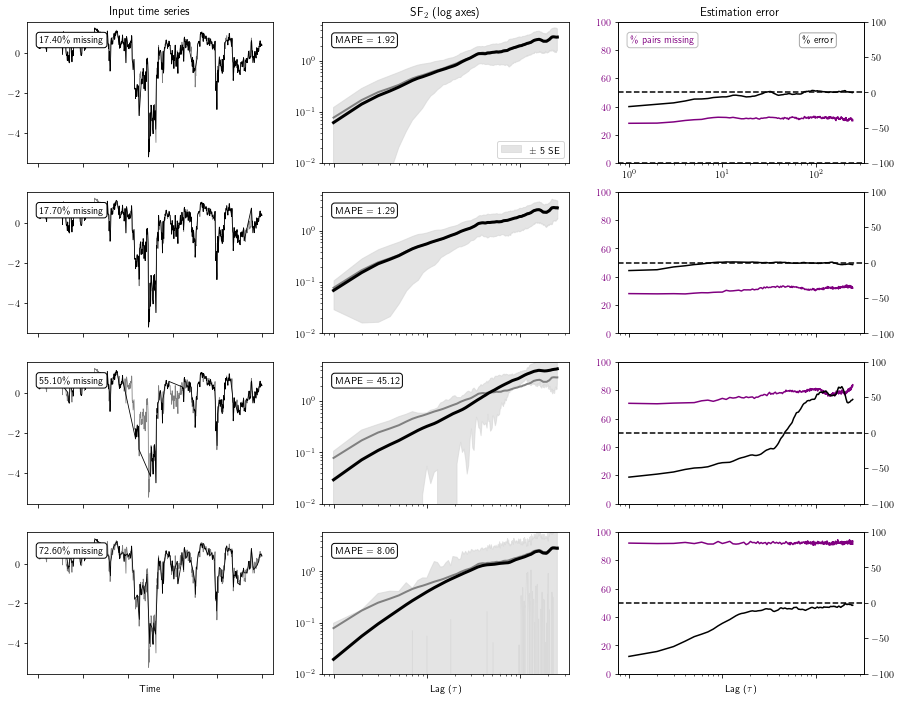

In [ ]:
sf.plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    "purple",
    input_ind,
    n,
    False,
)

## Do holistic analysis of errors

In [ ]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis
bad_outputs_df = pd.concat(
    [pd.concat(lst, keys=range(len(lst))) for lst in all_bad_outputs_list],
    keys=range(len(all_bad_outputs_list)),
)

# Renaming MultiIndex levels
bad_outputs_df.index.names = ["Original interval", "Interval version", "Lag"]

interp_outputs_df = pd.concat(
    [pd.concat(lst, keys=range(len(lst))) for lst in all_interp_outputs_list],
    keys=range(len(all_interp_outputs_list)),
)

# Renaming MultiIndex levels
interp_outputs_df.index.names = ["Original interval", "Interval version", "Lag"]

print(bad_outputs_df.info())
print(interp_outputs_df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6329580 entries, (0, 0, 1.0) to (1270, 19, 249.0)
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   lag                   float64
 1   n                     int64  
 2   sosf                  float64
 3   mapd                  float64
 4   sosf_se               float64
 5   missing_prop          float64
 6   error                 float64
 7   error_percent         float64
 8   missing_prop_overall  float64
 9   lint                  bool   
dtypes: bool(1), float64(8), int64(1)
memory usage: 470.9 MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6329580 entries, (0, 0, 1.0) to (1270, 19, 249.0)
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   lag                   float64
 1   n                     int64  
 2   sosf                  float64
 3   mapd                  float64
 4   sosf_se               float64
 5 

In [ ]:
import importlib

importlib.reload(sf)

<module 'sf_funcs' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\time_series_analysis\\sf_funcs.py'>

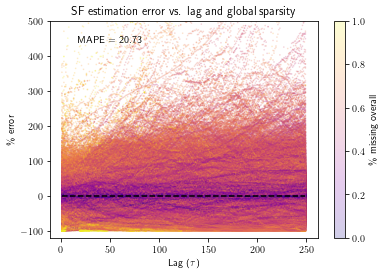

In [ ]:
# View trends as fn of OVERALL missing amount
sf.plot_error_trend_line(bad_outputs_df)

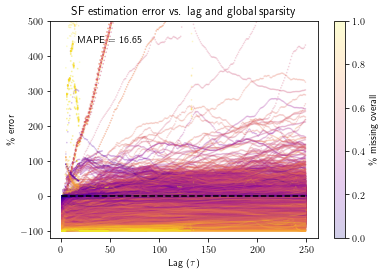

In [ ]:
sf.plot_error_trend_line(interp_outputs_df)

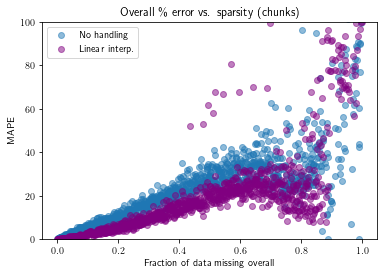

In [ ]:
sf.plot_error_trend_scatter(bad_outputs_df, interp_outputs_df)

In [ ]:
# Investigating weird spikes at small lag
interp_outputs_df.sort_values("error_percent", ascending=False).head(20)

lag  n      sosf      mapd  \
Original interval Interval version Lag                                 
74                15               17.0  17.0  8  1.662721  0.038351   
16                15               17.0  17.0  8  1.662721  0.038351   
74                14               17.0  17.0  8  1.662688  0.038351   
16                14               17.0  17.0  8  1.662688  0.038351   
74                16               17.0  17.0  8  1.656203  0.064919   
16                16               17.0  17.0  8  1.656203  0.064919   
                  12               17.0  17.0  8  1.336182  0.045287   
74                12               17.0  17.0  8  1.336182  0.045287   
                  1                17.0  17.0  8  1.336104  0.040087   
16                1                17.0  17.0  8  1.336104  0.040087   
                  7                17.0  17.0  8  1.336048  0.038351   
74                3                17.0  17.0  8  1.336048  0.038351   
                  6                17.0  17.0  8  1.336048  0.038351   
16                3                17.0  17.0  8  1.336048  0.038351   
                  6                17.0  17.0  8  1.336048  0.038351   
74                7                17.0  17.0  8  1.336048  0.038351   
                  0                17.0  17.0  8  1.336015  0.038351   
16                0                17.0  17.0  8  1.336015  0.038351   
                  18               17.0  17.0  8  1.335248  0.040087   
74                18               17.0  17.0  8  1.335248  0.040087   

                                          sosf_se  missing_prop     error  \
Original interval Interval version Lag                                      
74                15               17.0  0.000292      0.996948  1.662256   
16                15               17.0  0.000292      0.996948  1.662256   
74                14               17.0  0.000497      0.997965  1.662223   
16                14               17.0  0.000497      0.997965  1.662223   
74                16               17.0       NaN      0.998983  1.655738   
16                16               17.0       NaN      0.998983  1.655738   
                  12               17.0  0.000168      0.997965  1.335717   
74                12               17.0  0.000168      0.997965  1.335717   
                  1                17.0  0.000497      0.997965  1.335638   
16                1                17.0  0.000497      0.997965  1.335638   
                  7                17.0  0.000292      0.996948  1.335582   
74                3                17.0  0.000292      0.996948  1.335582   
                  6                17.0  0.000292      0.996948  1.335582   
16                3                17.0  0.000292      0.996948  1.335582   
                  6                17.0  0.000292      0.996948  1.335582   
74                7                17.0  0.000292      0.996948  1.335582   
                  0                17.0  0.000497      0.997965  1.335550   
16                0                17.0  0.000497      0.997965  1.335550   
                  18               17.0  0.000497      0.997965  1.334783   
74                18               17.0  0.000497      0.997965  1.334783   

                                         error_percent  missing_prop_overall  \
Original interval Interval version Lag                                         
74                15               17.0  357258.623401                 0.990   
16                15               17.0  357258.623401                 0.990   
74                14               17.0  357251.594717                 0.991   
16                14               17.0  357251.594717                 0.991   
74                16               17.0  355857.812427                 0.993   
16                16               17.0  355857.812427                 0.993   
                  12               17.0  287077.589573                 0.990   
74                12               17.0  2

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

In [ ]:
missing_measure = "missing_prop"
num_bins = 12

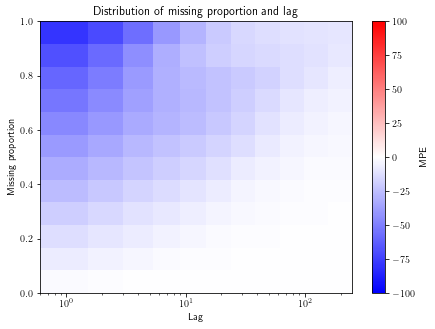

In [ ]:
# Log version
heatmap_bin_vals_log, heatmap_bin_edges_log, lookup_table_log = (
    sf.create_heatmap_lookup(interp_outputs_df, missing_measure, num_bins, log=True)
)

# If wanting linear bins, can then simply use the following:

# axs = sf.plot_heatmap(
#     heatmap_bin_vals,
#     heatmap_bin_edges,
#     "Missing proportion",
#     False,
# )

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_log[0],
    heatmap_bin_edges_log[1],
    heatmap_bin_vals_log.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.xlim(6e-1, 250)
plt.title("Distribution of missing proportion and lag")
ax.set_facecolor("black")
ax.set_xscale("log")
plt.show()

Check out sample size in each bin (above just shows where there is no data with black bins).
Below 2D histogram is not working for log bins, for some reason

Text(0.5, 1.0, 'Distribution of missing proportion and lag')

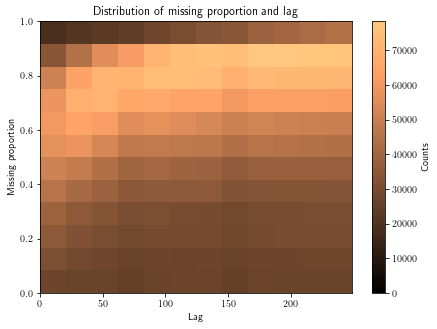

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
hb = ax.hist2d(
    interp_outputs_df["lag"],
    interp_outputs_df[missing_measure],
    bins=num_bins,
    cmap="copper",
    range=[[0, interp_outputs_df.lag.max()], [0, 1]],
)
plt.colorbar(hb[3], ax=ax, label="Counts")
hb[3].set_clim(0, hb[0].max())
plt.xlabel("Lag")
plt.ylabel("Missing proportion")
plt.title("Distribution of missing proportion and lag")

## Apply empirical correction factor to bad SFs


Correcting interval 0:



Correcting interval 1:
More than one nearest bin found!

Correcting interval 2:

Correcting interval 3:


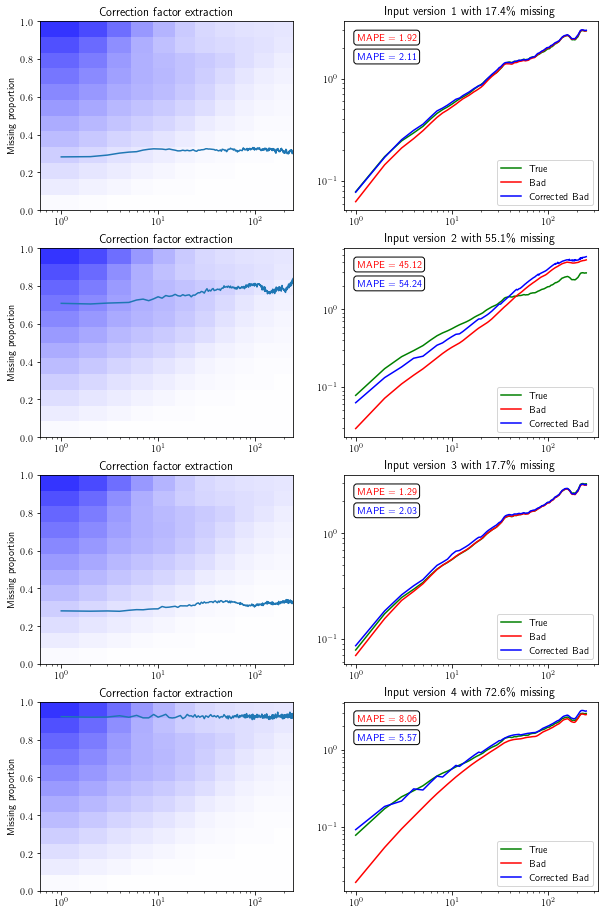

In [ ]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)

# Seems that smoothing does not help at this stage, perhaps given smoother heatmap to start with from larger sample size

fig, axs = plt.subplots(n, 2, figsize=(10, 4 * n))

for i in range(n):
    print(f"\nCorrecting interval {i}:")
    sf_corrected = sf.compute_scaling(
        all_interp_outputs_list[input_ind][i],
        missing_measure,
        lookup_table_log,
    )
    sf_corrected["error_corrected"] = (
        sf_corrected["sosf_corrected"] - good_outputs_list[input_ind]["sosf"]
    )
    sf_corrected["error_percent_corrected"] = (
        sf_corrected["error_corrected"] / good_outputs_list[input_ind]["sosf"] * 100
    )
    sf_corrected["error_corrected_sm"] = (
        sf_corrected["sosf_corrected_smoothed"] - good_outputs_list[input_ind]["sosf"]
    )
    sf_corrected["error_percent_corrected_sm"] = (
        sf_corrected["error_corrected_sm"] / good_outputs_list[input_ind]["sosf"] * 100
    )

    mape_bad = sf_corrected["error_percent"].abs().mean()
    mape_corrected = sf_corrected["error_percent_corrected"].abs().mean()
    mape_corrected_sm = sf_corrected["error_percent_corrected_sm"].abs().mean()

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.9),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="red",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.8),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    # axs[i, 1].annotate(
    #    "MAPE = {:.2f}".format(mape_corrected_sm),
    #    xy=(1, 1),
    #    xycoords="axes fraction",
    #    xytext=(0.05, 0.7),
    #    textcoords="axes fraction",
    #    transform=axs[i, 1].transAxes,
    #    c="orange",
    #    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    # )

    axs[i, 1].plot(good_outputs_list[input_ind]["sosf"], c="green", label="True")
    axs[i, 1].plot(all_interp_outputs_list[input_ind][i]["sosf"], c="red", label="Bad")
    # axs[i, 1].plot(
    #     sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(sf_corrected["sosf_corrected"], c="blue", label="Corrected Bad")
    #    axs[i, 1].plot(
    #        sf_corrected["sosf_corrected_smoothed"],
    #        c="orange",
    #        label="Corrected Bad Smoothed",
    #    )
    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].legend(loc="lower right")
    axs[i, 1].set_title(
        f"Input version {i+1} with {np.round(sf_corrected['missing_prop_overall'].values[0]*100, 2)}\% missing"
    )

    # if log is True:
    c = axs[i, 0].pcolormesh(
        heatmap_bin_edges_log[0],
        heatmap_bin_edges_log[1],
        heatmap_bin_vals_log.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=axs[i, 0], label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    # axs[i, 0].set_xlabel("Lag")
    axs[i, 0].plot(
        all_interp_outputs_list[input_ind][i]["lag"],
        all_interp_outputs_list[input_ind][i][missing_measure],
    )

    axs[i, 0].set_ylabel("Missing proportion")
    axs[i, 0].set_xlim(6e-1, 250)
    axs[i, 0].set_title("Correction factor extraction")
    axs[i, 0].set_xscale("log")

    # axs[i, 0] = sf.plot_heatmap(
    #     heatmap_bin_vals_log,
    #     heatmap_bin_edges_log,
    #     missing_measure=missing_measure,
    #     log=True,
    #     overlay_x=all_interp_outputs_list[input_ind][i]["lag"],
    #     overlay_y=all_interp_outputs_list[input_ind][i][missing_measure],
    #     subplot=axs[i, 0],
    # )

## Trialling 3D heatmap

In [ ]:
zedges = np.logspace(np.log10(interp_outputs_df.sosf.min(), interp_outputs_df.sosf.max(), num_bins+1)

SyntaxError: incomplete input (987529291.py, line 1)

In [ ]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        interp_outputs_df,
        missing_measure,
        10,
    )
)

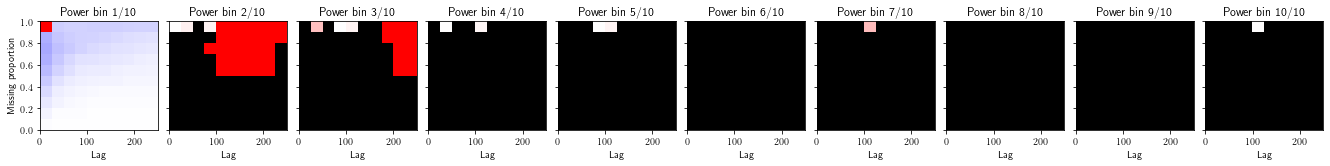

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(23, 2))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.1)
n_bins_power = len(heatmap_bin_edges_3d[2]) - 1
for i in range(n_bins_power):
    axs[i] = sf.plot_heatmap(
        heatmap_bin_vals_3d[:, :, i],
        heatmap_bin_edges_3d[:2],
        "Missing proportion",
        False,
        subplot=axs[i],
        # title=f"Hmap for power bin {i+1}/{n_bins_power}".format(
        #     np.round(heatmap_bin_edges[2][i], 2)
        # ),
    )
    axs[i].set_title(
        f"Power bin {i+1}/{n_bins_power}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    axs[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")

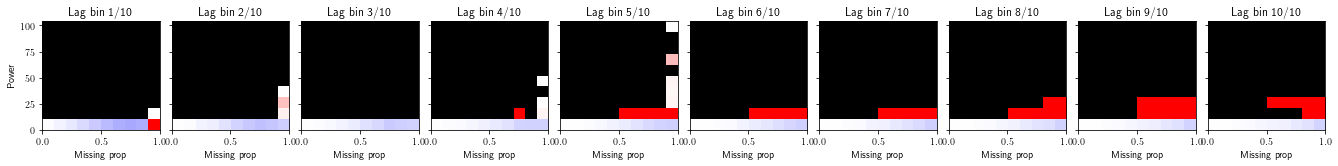

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(23, 2))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.1)
n_bins_power = len(heatmap_bin_edges_3d[2]) - 1
for i in range(n_bins_power):
    axs[i] = sf.plot_heatmap(
        heatmap_bin_vals_3d[i, :, :],
        heatmap_bin_edges_3d[1:],
        "Missing proportion",
        False,
        subplot=axs[i],
        # title=f"Hmap for power bin {i+1}/{n_bins_power}".format(
        #     np.round(heatmap_bin_edges[2][i], 2)
        # ),
    )
    axs[i].set_title(
        f"Lag bin {i+1}/{n_bins_power}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    axs[i].set_xlabel("Missing prop")
    axs[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")

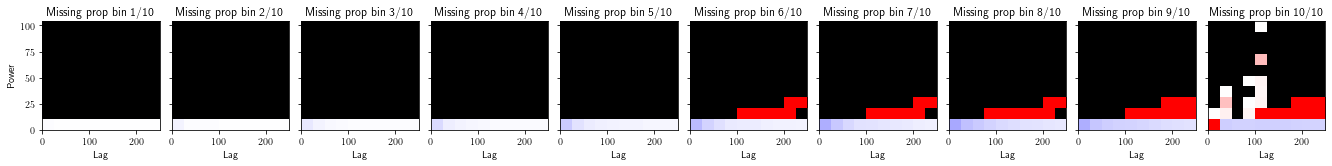

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(23, 2))
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.1)
n_bins_power = len(heatmap_bin_edges_3d[1]) - 1
for i in range(n_bins_power):
    axs[i] = sf.plot_heatmap(
        heatmap_bin_vals_3d[:, i, :],
        [heatmap_bin_edges_3d[0], heatmap_bin_edges_3d[2]],
        "Missing proportion",
        False,
        subplot=axs[i],
        # title=f"Hmap for power bin {i+1}/{n_bins_power}".format(
        #     np.round(heatmap_bin_edges[2][i], 2)
        # ),
    )
    axs[i].set_title(
        f"Missing prop bin {i+1}/{n_bins_power}".format(
            np.round(heatmap_bin_edges_3d[1][i], 2)
        )
    )
    axs[i].set_xlabel("Lag")
    axs[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")


Correcting interval 0:



Correcting interval 1:

Correcting interval 2:

Correcting interval 3:


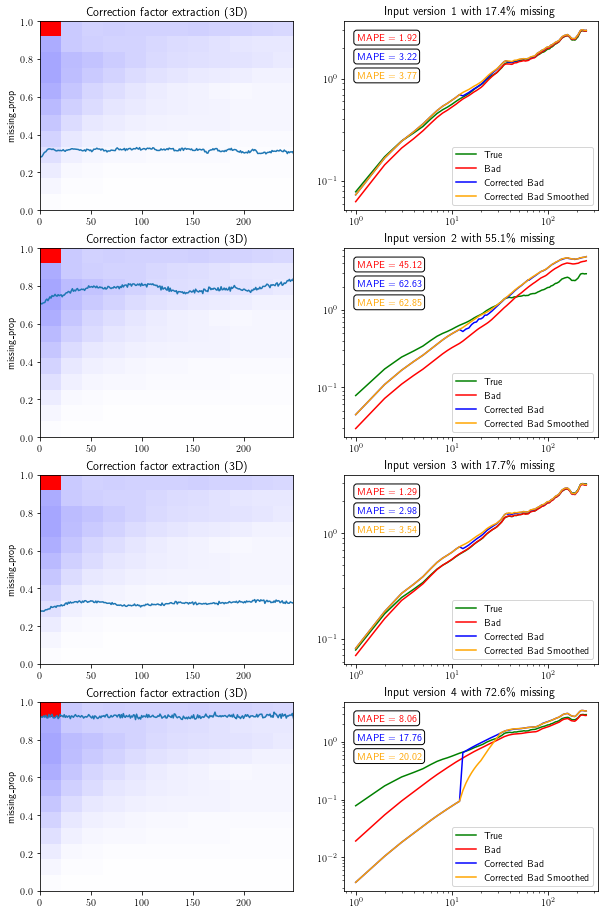

In [ ]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)

fig, axs = plt.subplots(n, 2, figsize=(10, 4 * n))  # Create a 3x1 plot

for i in range(n):
    print(f"\nCorrecting interval {i}:")
    sf_corrected = sf.compute_scaling_3d(
        all_interp_outputs_list[input_ind][i],
        missing_measure,
        lookup_table_3d,
    )
    sf_corrected["error_corrected"] = (
        sf_corrected["sosf_corrected"] - good_outputs_list[input_ind]["sosf"]
    )
    sf_corrected["error_percent_corrected"] = (
        sf_corrected["error_corrected"] / good_outputs_list[input_ind]["sosf"] * 100
    )
    sf_corrected["error_corrected_sm"] = (
        sf_corrected["sosf_corrected_smoothed"] - good_outputs_list[input_ind]["sosf"]
    )
    sf_corrected["error_percent_corrected_sm"] = (
        sf_corrected["error_corrected_sm"] / good_outputs_list[input_ind]["sosf"] * 100
    )

    mape_bad = sf_corrected["error_percent"].abs().mean()
    mape_corrected = sf_corrected["error_percent_corrected"].abs().mean()
    mape_corrected_sm = sf_corrected["error_percent_corrected_sm"].abs().mean()

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_bad),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.9),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="red",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.8),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="blue",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].annotate(
        "MAPE = {:.2f}".format(mape_corrected_sm),
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.05, 0.7),
        textcoords="axes fraction",
        transform=axs[i, 1].transAxes,
        c="orange",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    axs[i, 1].plot(good_outputs_list[input_ind]["sosf"], c="green", label="True")
    axs[i, 1].plot(all_interp_outputs_list[input_ind][i]["sosf"], c="red", label="Bad")
    # axs[i, 1].plot(
    #     sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
    # )
    axs[i, 1].plot(sf_corrected["sosf_corrected"], c="blue", label="Corrected Bad")
    axs[i, 1].plot(
        sf_corrected["sosf_corrected_smoothed"],
        c="orange",
        label="Corrected Bad Smoothed",
    )
    axs[i, 1].semilogx()
    axs[i, 1].semilogy()
    axs[i, 1].legend(loc="lower right")
    axs[i, 1].set_title(
        f"Input version {i+1} with {np.round(sf_corrected['missing_prop_overall'].values[0]*100, 2)}\% missing"
    )

    axs[i, 0] = sf.plot_heatmap(
        heatmap_bin_vals,
        heatmap_bin_edges,
        missing_measure=missing_measure,
        log=False,
        overlay_x=all_interp_outputs_list[input_ind][i]["lag"],
        overlay_y=all_interp_outputs_list[input_ind][i][missing_measure],
        subplot=axs[i, 0],
        title="Correction factor extraction (3D)",
    )

## Calculate alternative estimators

In [ ]:
# Compute the structure function
X = good_inputs_list[0]
lags = np.arange(1, 0.25 * len(X))
powers = [0.5, 2]

good_output = sf.compute_sf(pd.DataFrame(X), lags, powers)
good_output["ch_numerator"] = good_output["0.5_mean"] ** 4
good_output["ch"] = good_output["ch_numerator"] / (0.457 + (0.494 / good_output["n"]))
good_output["dowd"] = (good_output["mapd"] ** 2) * 2.198

# Compute the structure function for the bad data
X = all_bad_inputs_list[0][1]
bad_output = sf.compute_sf(pd.DataFrame(X), lags, powers)
bad_output["ch_numerator"] = bad_output["0.5_mean"] ** 4
bad_output["ch"] = bad_output["ch_numerator"] / (0.457 + (0.494 / bad_output["n"]))
bad_output["dowd"] = (bad_output["mapd"] ** 2) * 2.198

# Compute the structure function for the interpolated data
X = all_interp_inputs_list[0][1]
interp_output = sf.compute_sf(pd.DataFrame(X), lags, powers)
interp_output["ch_numerator"] = interp_output["0.5_mean"] ** 4
interp_output["ch"] = interp_output["ch_numerator"] / (
    0.457 + (0.494 / interp_output["n"])
)
interp_output["dowd"] = (interp_output["mapd"] ** 2) * 2.198

## Investigating skew and kurtosis at given lags

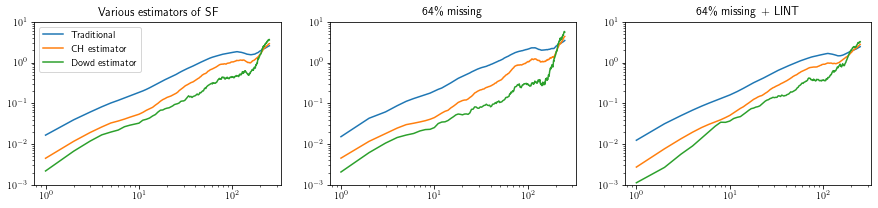

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].plot(good_output["sosf"], label="Traditional")
ax[0].plot(good_output["ch"], label="CH estimator")
ax[0].plot(good_output["dowd"], label="Dowd estimator")
ax[0].semilogx()
ax[0].semilogy()
ax[0].set_title("Various estimators of SF")
ax[0].legend()

ax[1].plot(bad_output["sosf"], label="Traditional)")
ax[1].plot(bad_output["ch"], label="CH estimator")
ax[1].plot(bad_output["dowd"], label="Dowd estimator")
ax[1].semilogx()
ax[1].semilogy()
ax[1].set_title("64\% missing")

ax[2].plot(interp_output["sosf"], label="Traditional")
ax[2].plot(interp_output["ch"], label="CH estimator")
ax[2].plot(interp_output["dowd"], label="Dowd estimator")
ax[2].semilogx()
ax[2].semilogy()
ax[2].set_title("64\% missing + LINT")

# Set common ylim
ax[0].set_ylim([1e-3, 1e1])
ax[1].set_ylim([1e-3, 1e1])
ax[2].set_ylim([1e-3, 1e1])

plt.show()

In [ ]:
sq_diffs_lag_5 = good_output.loc[good_output["lag"] == 5, "sq_diffs"]
sq_diffs_lag_50 = good_output.loc[good_output["lag"] == 50, "sq_diffs"]
sq_diffs_lag_500 = good_output.loc[good_output["lag"] == 500, "sq_diffs"]

# Calculate and add the skew of each dataset as an annotation
skew_lag_5 = np.round(pd.Series(np.concatenate(sq_diffs_lag_5.values)).skew(), 2)
skew_lag_50 = np.round(pd.Series(np.concatenate(sq_diffs_lag_50.values)).skew(), 2)
skew_lag_500 = np.round(pd.Series(np.concatenate(sq_diffs_lag_500.values)).skew(), 2)

plt.hist(
    sq_diffs_lag_5,
    bins=20,
    alpha=0.5,
    label="Lag 5: skew={}".format(skew_lag_5),
    color="red",
)
plt.hist(
    sq_diffs_lag_50,
    bins=20,
    alpha=0.5,
    label="Lag 50: skew={}".format(skew_lag_50),
    color="blue",
)
plt.hist(
    sq_diffs_lag_500,
    bins=20,
    alpha=0.5,
    label="Lag 500: skew={}".format(skew_lag_500),
    color="yellow",
)
plt.legend()
plt.xlim([0, 13])
plt.ylim([0, 4000])
plt.title("Distribution of squared increments for different lags,\nclean input")
plt.show()

KeyError: 'sq_diffs'

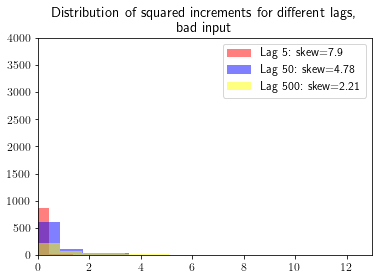

In [ ]:
sq_diffs_lag_5 = bad_output.loc[bad_output["lag"] == 5, "sq_diffs"]
sq_diffs_lag_50 = bad_output.loc[bad_output["lag"] == 50, "sq_diffs"]
sq_diffs_lag_500 = bad_output.loc[bad_output["lag"] == 500, "sq_diffs"]

# Calculate and add the skew of each dataset as an annotation
skew_lag_5 = np.round(pd.Series(np.concatenate(sq_diffs_lag_5.values)).skew(), 2)
skew_lag_50 = np.round(pd.Series(np.concatenate(sq_diffs_lag_50.values)).skew(), 2)
skew_lag_500 = np.round(pd.Series(np.concatenate(sq_diffs_lag_500.values)).skew(), 2)

plt.hist(
    sq_diffs_lag_5,
    bins=20,
    alpha=0.5,
    label="Lag 5: skew={}".format(skew_lag_5),
    color="red",
)
plt.hist(
    sq_diffs_lag_50,
    bins=20,
    alpha=0.5,
    label="Lag 50: skew={}".format(skew_lag_50),
    color="blue",
)
plt.hist(
    sq_diffs_lag_500,
    bins=20,
    alpha=0.5,
    label="Lag 500: skew={}".format(skew_lag_500),
    color="yellow",
)
plt.legend()
plt.xlim([0, 13])
plt.ylim([0, 4000])
plt.title("Distribution of squared increments for different lags,\n bad input")
plt.show()

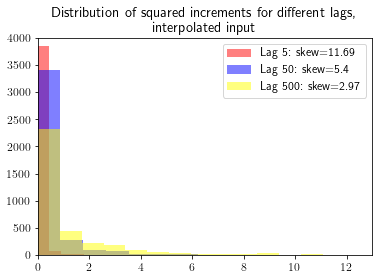

In [ ]:
sq_diffs_lag_5 = interp_output.loc[interp_output["lag"] == 5, "sq_diffs"]
sq_diffs_lag_50 = interp_output.loc[interp_output["lag"] == 50, "sq_diffs"]
sq_diffs_lag_500 = interp_output.loc[interp_output["lag"] == 500, "sq_diffs"]

# Calculate and add the skew of each dataset as an annotation
skew_lag_5 = np.round(pd.Series(np.concatenate(sq_diffs_lag_5.values)).skew(), 2)
skew_lag_50 = np.round(pd.Series(np.concatenate(sq_diffs_lag_50.values)).skew(), 2)
skew_lag_500 = np.round(pd.Series(np.concatenate(sq_diffs_lag_500.values)).skew(), 2)

plt.hist(
    sq_diffs_lag_5,
    bins=20,
    alpha=0.5,
    label="Lag 5: skew={}".format(skew_lag_5),
    color="red",
)
plt.hist(
    sq_diffs_lag_50,
    bins=20,
    alpha=0.5,
    label="Lag 50: skew={}".format(skew_lag_50),
    color="blue",
)
plt.hist(
    sq_diffs_lag_500,
    bins=20,
    alpha=0.5,
    label="Lag 500: skew={}".format(skew_lag_500),
    color="yellow",
)
plt.legend()
plt.xlim([0, 13])
plt.ylim([0, 4000])
plt.title("Distribution of squared increments for different lags,\n interpolated input")
plt.show()

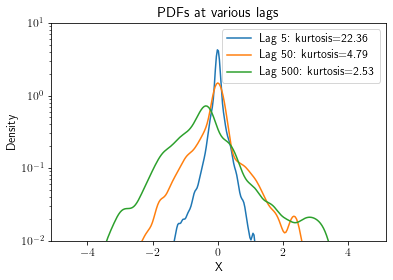

In [ ]:
# Raw increments
dax_lag5 = pd.Series(X).shift(-5) - X
dax_lag50 = pd.Series(X).shift(-50) - X
dax_lag500 = pd.Series(X).shift(-500) - X


import seaborn as sns

sns.kdeplot(
    dax_lag5, label="Lag 5: kurtosis={}".format(np.round(dax_lag5.kurtosis(), 2))
)
sns.kdeplot(
    dax_lag50, label="Lag 50: kurtosis={}".format(np.round(dax_lag50.kurtosis(), 2))
)
sns.kdeplot(
    dax_lag500, label="Lag 500: kurtosis={}".format(np.round(dax_lag500.kurtosis(), 2))
)
plt.yscale("log")  # Set y-axis scale to logarithmic
plt.xlabel("X")
plt.ylabel("Density")
plt.legend()
plt.title("PDFs at various lags")
plt.ylim(1e-2, 1e1)
plt.show()

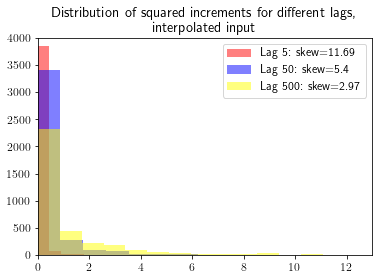

In [ ]:
sq_diffs_lag_5 = interp_output.loc[interp_output["lag"] == 5, "sq_diffs"]
sq_diffs_lag_50 = interp_output.loc[interp_output["lag"] == 50, "sq_diffs"]
sq_diffs_lag_500 = interp_output.loc[interp_output["lag"] == 500, "sq_diffs"]

# Calculate and add the skew of each dataset as an annotation
skew_lag_5 = np.round(pd.Series(np.concatenate(sq_diffs_lag_5.values)).skew(), 2)
skew_lag_50 = np.round(pd.Series(np.concatenate(sq_diffs_lag_50.values)).skew(), 2)
skew_lag_500 = np.round(pd.Series(np.concatenate(sq_diffs_lag_500.values)).skew(), 2)

plt.hist(
    sq_diffs_lag_5,
    bins=20,
    alpha=0.5,
    label="Lag 5: skew={}".format(skew_lag_5),
    color="red",
)
plt.hist(
    sq_diffs_lag_50,
    bins=20,
    alpha=0.5,
    label="Lag 50: skew={}".format(skew_lag_50),
    color="blue",
)
plt.hist(
    sq_diffs_lag_500,
    bins=20,
    alpha=0.5,
    label="Lag 500: skew={}".format(skew_lag_500),
    color="yellow",
)
plt.legend()
plt.xlim([0, 13])
plt.ylim([0, 4000])
plt.title("Distribution of squared increments for different lags,\n interpolated input")
plt.show()